<a href="https://colab.research.google.com/github/StructuresComp/DER_Book_Codes/blob/master/Beam_Model_Neural_Network_Energy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from autograd import grad, hessian

from logging import ERROR

#Helper function

In [ ]:
def crossMat(a):
    """
    Returns the cross product matrix of vector 'a'.

    Parameters:
    a : np.ndarray
        A 3-element array representing a vector.

    Returns:
    A : np.ndarray
        The cross product matrix corresponding to vector 'a'.
    """
    A = np.array([[0, -a[2], a[1]],
                  [a[2], 0, -a[0]],
                  [-a[1], a[0], 0]])

    return A

# Gradient and Hessian of Strains (axial stretch) on one edge in 2D

In [ ]:
def get_strain_stretch_edge2D(node0, node1, l_k):
  '''
    Compute the axial stretch of a edge connecting node0 and node1.
    The code does not change even if we move from 2D to 3D.

    Parameters:
        node0 (array-like): Coordinates of the first node (start of the edge),
                            typically a 2-element array [x0, y0] for the 2D case.
        node1 (array-like): Coordinates of the second node (end of the edge),
                            typically a 2-element array [x1, y1].
        l_k (float): Reference (undeformed) length of the edge.

    Returns:
        epsX (float): Axial stretch of the edge, defined as:
                      epsX = (current_length / reference_length) - 1,
                      where current_length is the Euclidean distance between node0 and node1.

    Description:
        The function calculates the axial stretch of a 2D edge by:
        1. Computing the edge vector as the difference between node1 and node0.
        2. Calculating the current length of the edge as the Euclidean norm of the edge vector.
        3. Using the ratio of the current length to the reference length to compute the stretch.
  '''
  edge = node1 - node0
  edgeLen = np.linalg.norm(edge)
  epsX = edgeLen / l_k - 1
  return epsX

In [ ]:
def test_get_strain_stretch_edge2D():
  '''
  This function shows the usage of get_strain_stretch_edge2D() function.
  '''
  node0 = np.array([0.0, 0.0])
  node1 = np.array([1.0, 1.0])
  l_k = 1.5
  stretch = get_strain_stretch_edge2D(node0, node1, l_k)
  print("Axial stretch:", stretch)

# test_get_strain_stretch_edge2D()

In [ ]:
def grad_and_hess_strain_stretch_edge2D(node0, node1, l_k):
  '''
  Compute the gradient and hessian of the axial stretch of a 2D edge with
  respect to the dof vector (4 dofs: x,y coordinates of the two nodes)

  Inputs:
  node0: 2x1 vector - position of the first node
  node1: 2x1 vector - position of the last node
  l_k: reference length (undeformed) of the edge

  Outputs:
  dF: 4x1  vector - gradient of axial stretch between node0 and node 1.
  dJ: 4x4 vector - hessian of axial stretch between node0 and node 1.
  '''

  edge = node1 - node0
  edgeLen = np.linalg.norm(edge)
  tangent = edge / edgeLen
  epsX = get_strain_stretch_edge2D(node0, node1, l_k)

  dF_unit = tangent / l_k # gradient of stretch with respect to the edge vector
  dF = np.zeros((4))
  dF[0:2] = - dF_unit
  dF[2:4] = dF_unit

  # M (see below) is the Hessian of square(stretch) with respect to the edge vector
  Id3 = np.eye(2)
  M = 2.0 / l_k * ((1 / l_k - 1 / edgeLen) * Id3 + 1 / edgeLen * ( np.outer( edge, edge ) ) / edgeLen ** 2)

  # M is the Hessian of stretch with respect to the edge vector
  if epsX == 0: # Edge case
    M2 = np.zeros_like(M)
  else:
    M2 = 1.0/(2.0*epsX) * (M - 2.0*np.outer(dF_unit,dF_unit))

  dJ = np.zeros((4,4))
  dJ[0:2,0:2] = M2
  dJ[2:4,2:4] = M2
  dJ[0:2,2:4] = - M2
  dJ[2:4,0:2] = - M2

  return dF,dJ

In [ ]:
def test_stretch_edge2D():
  '''
  This function tests the outputs (gradient and hessian) of
  grad_and_hess_strain_stretch_edge2D() against their finite difference
  approximations.
  '''

  # Undeformed configuration (2 nodes, 1 edge)
  x0 = np.random.rand(4)
  l_k = np.linalg.norm(x0[0:2] - x0[2:4])

  # Deformed configuration (2 nodes, 1 edge)
  x = np.random.rand(4)
  node0 = x[0:2]
  node1 = x[2:4]

  # Stretching force and Jacobian
  grad, hess = grad_and_hess_strain_stretch_edge2D(node0, node1, l_k)

  # Use FDM to compute Fs and Js
  change = 1e-6
  strain_ground = get_strain_stretch_edge2D(node0, node1, l_k)
  grad_fdm = np.zeros(4)
  hess_fdm = np.zeros((4,4))
  for c in range(4):
    x_plus = x.copy()
    x_plus[c] += change
    node0_plus = x_plus[0:2]
    node1_plus = x_plus[2:4]
    strain_plus = get_strain_stretch_edge2D(node0_plus, node1_plus, l_k)
    grad_fdm[c] = (strain_plus - strain_ground) / change

    grad_change, _ = grad_and_hess_strain_stretch_edge2D(node0_plus, node1_plus, l_k)
    hess_fdm[:,c] = (grad_change - grad) / change

  # First plot: Forces (Gradients)
  plt.figure(1)  # Equivalent to MATLAB's figure(1)
  plt.plot(grad, 'ro', label='Analytical')  # Plot analytical forces
  plt.plot(grad_fdm, 'b^', label='Finite Difference')  # Plot finite difference forces
  plt.legend(loc='best')  # Display the legend
  plt.xlabel('Index')  # X-axis label
  plt.ylabel('Gradient')  # Y-axis label
  plt.title('Forces (Gradients) Comparison')  # Optional title
  plt.show()  # Show the plot

  # Second plot: Hessians
  plt.figure(2)  # Equivalent to MATLAB's figure(2)
  plt.plot(hess.flatten(), 'ro', label='Analytical')  # Flatten and plot analytical Hessian
  plt.plot(hess_fdm.flatten(), 'b^', label='Finite Difference')  # Flatten and plot finite difference Hessian
  plt.legend(loc='best')  # Display the legend
  plt.xlabel('Index')  # X-axis label
  plt.ylabel('Hessian')  # Y-axis label
  plt.title('Hessian Comparison')  # Optional title
  plt.show()  # Show the plot
  return

# test_stretch_edge2D()

# Gradient and Hessian of Strains (axial stretch) on one node in 2D
**Node-based formulation allows us to easily have coupled terms like stretch times curvature. Otherwise, curvature and twist are node-based, whereas, conventionally strain is edge-based. It is straightforward to formulate edge-based stretch.**

In [ ]:
def get_strain_stretch2D(node0, node1, node2=None, l_0=1.0, l_1=1.0):
  '''
    Compute the axial stretch of an node (node1) based on the stretches on the two edges
    connected to that node. The first edge connects node0 and node1, whereas
    the second edge connects node1 and node2. The code does not change even if
    we move from 2D to 3D.

    Parameters:
        node0 (array-like): Coordinates of the first node (start of the first edge),
                            typically a 2-element array [x0, y0] for the 2D case.
        node1 (array-like): Coordinates of the second node (end of the first edge
                            and start of the second edge),
                            typically a 2-element array [x1, y1].
        node2 (array-like): Coordinates of the third node (end of the second edge),
                            typically a 2-element array [x2, y2].
        l_0 (float): Reference (undeformed) length of the first edge.
        l_1 (float): Reference (undeformed) length of the second edge.

    Returns:
        epsilon_1 (float): Axial stretch at node1, defined as the average of the
                            stretches on the two edges connected to node1. If
                            only two nodes are specified, the stretch is defined
                            as half of the stretch on the first edge.
  '''
  # Convert inputs to numpy arrays for vectorized operations
  node0 = np.array(node0, dtype=float)
  node1 = np.array(node1, dtype=float)

  if node2 is not None:
    # If all the nodes are specified (i.e., node1 is an internal node),
    # computation is as usual (average of the strains of the two edges).
    node2 = np.array(node2, dtype=float)

    stretch_firstEdge  = get_strain_stretch_edge2D(node0, node1, l_0)
    stretch_secondEdge = get_strain_stretch_edge2D(node1, node2, l_1)

    epsilon_1 = 0.5 * stretch_firstEdge + 0.5 * stretch_secondEdge
  else:
    # Simplified case if only two nodes are specified.
    epsilon_1 = 0.5 * get_strain_stretch_edge2D(node0, node1, l_0)

  return epsilon_1

In [ ]:
def grad_and_hess_strain_stretch2D(node0, node1, node2=None, l_0=1.0, l_1=1.0):
  '''
  Compute the gradient and hessian of the axial stretch at node1 with
  respect to the dof vector (6 dofs: x,y coordinates of three nodes).

  Inputs:
  node0: 2x1 vector - position of the first node
  node1: 2x1 vector - position of the middle node
  node2: 2x1 vector - position of the last node
  l_0: reference length (undeformed) of the first edge
  l_1: reference length (undeformed) of the second edge

  Outputs:
  dF: 6x1  vector - gradient of axial stretch between node0 and node 1.
  dJ: 6x6 vector - hessian of axial stretch between node0 and node 1.

  Description:
  The gradient and hessian at node1 is the average of the gradients and hessians
  of the two edges (one between node0 and node1 and the other one between node1
  and node2).
  '''
  # Ensure inputs are numpy arrays
  node0 = np.array(node0, dtype=float)
  node1 = np.array(node1, dtype=float)

  if node2 is not None:
    node2 = np.array(node2, dtype=float)

    G_varepsilon = np.zeros(6)
    H_varepsilon = np.zeros((6, 6))

    G1, H1 = grad_and_hess_strain_stretch_edge2D(node0, node1, l_0)
    G2, H2 = grad_and_hess_strain_stretch_edge2D(node1, node2, l_1)
    G_varepsilon[0:4] = 0.5 * G1
    G_varepsilon[2:6] += 0.5 * G2
    H_varepsilon[0:4,0:4] = 0.5 * H1
    H_varepsilon[2:6,2:6] += 0.5 * H2
  else:
    G1, H1 = grad_and_hess_strain_stretch_edge2D(node0, node1, l_0)
    G_varepsilon = 0.5 * G1
    H_varepsilon = 0.5 * H1

  return G_varepsilon, H_varepsilon

In [ ]:
def test_stretch_node2D():
  '''
  This function tests the outputs (gradient and hessian) of
  grad_and_hess_strain_stretch2D() against their finite difference
  approximations.
  '''

  # Undeformed configuration (2 nodes, 1 edge)
  x0 = np.random.rand(6)
  l_0 = np.linalg.norm(x0[0:2] - x0[2:4])
  l_1 = np.linalg.norm(x0[2:4] - x0[4:6])

  # Deformed configuration (2 nodes, 1 edge)
  x = np.random.rand(6)
  node0 = x[0:2]
  node1 = x[2:4]
  node2 = x[4:6]

  # Stretching force and Jacobian
  grad, hess = grad_and_hess_strain_stretch2D(node0, node1, node2, l_0, l_1)

  # Use FDM to compute Fs and Js
  change = 1e-6
  strain_ground = get_strain_stretch2D(node0, node1, node2, l_0, l_1)
  grad_fdm = np.zeros(6)
  hess_fdm = np.zeros((6,6))
  for c in range(6):
    x_plus = x.copy()
    x_plus[c] += change
    node0_plus = x_plus[0:2]
    node1_plus = x_plus[2:4]
    node2_plus = x_plus[4:6]
    strain_plus = get_strain_stretch2D(node0_plus, node1_plus, node2_plus, \
                                          l_0, l_1)
    grad_fdm[c] = (strain_plus - strain_ground) / change

    grad_change, _ = grad_and_hess_strain_stretch2D(node0_plus, node1_plus, \
                                                  node2_plus, l_0, l_1)
    hess_fdm[:,c] = (grad_change - grad) / change

  # First plot: Forces (Gradients)
  plt.figure(1)  # Equivalent to MATLAB's figure(1)
  plt.plot(grad, 'ro', label='Analytical')  # Plot analytical forces
  plt.plot(grad_fdm, 'b^', label='Finite Difference')  # Plot finite difference forces
  plt.legend(loc='best')  # Display the legend
  plt.xlabel('Index')  # X-axis label
  plt.ylabel('Gradient')  # Y-axis label
  plt.title('Forces (Gradients) Comparison')  # Optional title
  plt.show()  # Show the plot

  # Second plot: Hessians
  plt.figure(2)  # Equivalent to MATLAB's figure(2)
  plt.plot(hess.flatten(), 'ro', label='Analytical')  # Flatten and plot analytical Hessian
  plt.plot(hess_fdm.flatten(), 'b^', label='Finite Difference')  # Flatten and plot finite difference Hessian
  plt.legend(loc='best')  # Display the legend
  plt.xlabel('Index')  # X-axis label
  plt.ylabel('Hessian')  # Y-axis label
  plt.title('Hessian Comparison')  # Optional title
  plt.show()  # Show the plot
  return

# test_stretch_node2D()

# Gradient and Hessian of Strains (curvature in 2D)

In [ ]:
def get_strain_curvature2D(node0, node1, node2):
  '''
  Compute the curvature (scalar) in 2D at node1 that is connected to node0 and
  node2.

  Inputs:
  node0: 2x1 vector - position of the first node
  node1: 2x1 vector - position of the middle node
  node2: 2x1 vector - position of the last node

  Outputs:
  kappa1: scalar - curvature at node1 (a scalar)

  Description:
  The function converts 2D nodes into 3D; computers the curvature binormal
  (a vector) and extracts the scalar curvature (z-component of curvature
  binormal)
  '''

  # Nodes in 3D
  node0 = np.array([node0[0], node0[1], 0.0])
  node1 = np.array([node1[0], node1[1], 0.0])
  node2 = np.array([node2[0], node2[1], 0.0])

  # Edge vectors
  ee = node1 - node0
  ef = node2 - node1

  # Norms of edge vectors
  norm_e = np.linalg.norm(ee)
  norm_f = np.linalg.norm(ef)

  # Unit tangents
  te = ee / norm_e
  tf = ef / norm_f

  # Curvature binormal
  kb = 2.0 * np.cross(te, tf) / (1.0 + np.dot(te, tf))

  # Curvature
  kappa1 = kb[2]

  return kappa1

In [ ]:
def grad_and_hess_strain_curvature2D(node0, node1, node2):
  '''
  Compute the gradient and hessian of the curvature at node1 with
  respect to the dof vector (6 dofs: x,y coordinates of three nodes).

  Inputs:
  node0: 2x1 vector - position of the first node
  node1: 2x1 vector - position of the middle node
  node2: 2x1 vector - position of the last node

  Outputs:
  dF: 6x1 vector - gradient of curvature at node 1
  dJ: 6x6 vector - hessian of curvature at node 1.

  Description:
  The gradient and hessian at node1 is the average of the gradients and hessians
  of the two edges (one between node0 and node1 and the other one between node1
  and node2).
  '''

  # Nodes in 3D
  node0 = np.array([node0[0], node0[1], 0.0])
  node1 = np.array([node1[0], node1[1], 0.0])
  node2 = np.array([node2[0], node2[1], 0.0])

  # Unit vectors along z-axis
  m2e = np.array([0, 0, 1])
  m2f = np.array([0, 0, 1])

  # Initialize gradient of curvature
  gradKappa = np.zeros(6)

  # Edge vectors
  ee = node1 - node0
  ef = node2 - node1

  # Norms of edge vectors
  norm_e = np.linalg.norm(ee)
  norm_f = np.linalg.norm(ef)

  # Unit tangents
  te = ee / norm_e
  tf = ef / norm_f

  # Curvature binormal
  kb = 2.0 * np.cross(te, tf) / (1.0 + np.dot(te, tf))

  chi = 1.0 + np.dot(te, tf)
  tilde_t = (te + tf) / chi
  tilde_d2 = (m2e + m2f) / chi

  # Curvature
  kappa1 = get_strain_curvature2D(node0, node1, node2)

  # Gradient of kappa1 with respect to edge vectors
  Dkappa1De = 1.0 / norm_e * (-kappa1 * tilde_t + np.cross(tf, tilde_d2))
  Dkappa1Df = 1.0 / norm_f * (-kappa1 * tilde_t - np.cross(te, tilde_d2))

  # Populate the gradient of kappa
  gradKappa[0:2] = -Dkappa1De[0:2]
  gradKappa[2:4] = Dkappa1De[0:2] - Dkappa1Df[0:2]
  gradKappa[4:6] = Dkappa1Df[0:2]

  # Compute the Hessian (second derivative of kappa)
  DDkappa1 = np.zeros((6, 6))

  norm2_e = norm_e**2
  norm2_f = norm_f**2

  Id3 = np.eye(3)

  # Helper matrices for second derivatives
  tt_o_tt = np.outer(tilde_t, tilde_t)
  tmp = np.cross(tf, tilde_d2)
  tf_c_d2t_o_tt = np.outer(tmp, tilde_t)
  kb_o_d2e = np.outer(kb, m2e)

  D2kappa1De2 = (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt - tf_c_d2t_o_tt.T) / norm2_e - \
    kappa1 / (chi * norm2_e) * (Id3 - np.outer(te, te)) + \
    (kb_o_d2e + kb_o_d2e.T) / (4 * norm2_e)

  tmp = np.cross(te, tilde_d2)
  te_c_d2t_o_tt = np.outer(tmp, tilde_t)
  tt_o_te_c_d2t = te_c_d2t_o_tt.T
  kb_o_d2f = np.outer(kb, m2f)

  D2kappa1Df2 = (2 * kappa1 * tt_o_tt + te_c_d2t_o_tt + te_c_d2t_o_tt.T) / norm2_f - \
                  kappa1 / (chi * norm2_f) * (Id3 - np.outer(tf, tf)) + \
                  (kb_o_d2f + kb_o_d2f.T) / (4 * norm2_f)
  D2kappa1DeDf = -kappa1 / (chi * norm_e * norm_f) * (Id3 + np.outer(te, tf)) \
                  + 1.0 / (norm_e * norm_f) * (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt + \
                  tt_o_te_c_d2t - crossMat(tilde_d2))
  D2kappa1DfDe = D2kappa1DeDf.T

  # Populate the Hessian of kappa
  DDkappa1[0:2, 0:2] = D2kappa1De2[0:2, 0:2]
  DDkappa1[0:2, 2:4] = -D2kappa1De2[0:2, 0:2] + D2kappa1DeDf[0:2, 0:2]
  DDkappa1[0:2, 4:6] = -D2kappa1DeDf[0:2, 0:2]
  DDkappa1[2:4, 0:2] = -D2kappa1De2[0:2, 0:2] + D2kappa1DfDe[0:2, 0:2]
  DDkappa1[2:4, 2:4] = D2kappa1De2[0:2, 0:2] - D2kappa1DeDf[0:2, 0:2] - \
                         D2kappa1DfDe[0:2, 0:2] + D2kappa1Df2[0:2, 0:2]
  DDkappa1[2:4, 4:6] = D2kappa1DeDf[0:2, 0:2] - D2kappa1Df2[0:2, 0:2]
  DDkappa1[4:6, 0:2] = -D2kappa1DfDe[0:2, 0:2]
  DDkappa1[4:6, 2:4] = D2kappa1DfDe[0:2, 0:2] - D2kappa1Df2[0:2, 0:2]
  DDkappa1[4:6, 4:6] = D2kappa1Df2[0:2, 0:2]


  return gradKappa, DDkappa1

In [ ]:
def test_curvature2D():
  '''
  This function tests the outputs (gradient and hessian) of
  grad_and_hess_strain_curvature2D() against their finite difference
  approximations.
  '''

  # Deformed configuration (3 nodes)
  x = np.random.rand(6)
  node0 = x[0:2]
  node1 = x[2:4]
  node2 = x[4:6]

  # Stretching force and Jacobian
  grad, hess = grad_and_hess_strain_curvature2D(node0, node1, node2)

  # Use FDM to compute Fs and Js
  change = 1e-6
  strain_ground = get_strain_curvature2D(node0, node1, node2)
  grad_fdm = np.zeros(6)
  hess_fdm = np.zeros((6,6))
  for c in range(6):
    x_plus = x.copy()
    x_plus[c] += change
    node0_plus = x_plus[0:2]
    node1_plus = x_plus[2:4]
    node2_plus = x_plus[4:6]
    strain_plus = get_strain_curvature2D(node0_plus, node1_plus, node2_plus)
    grad_fdm[c] = (strain_plus - strain_ground) / change

    grad_change, _ = grad_and_hess_strain_curvature2D(node0_plus, node1_plus, node2_plus)
    hess_fdm[:,c] = (grad_change - grad) / change

  # First plot: Forces (Gradients)
  plt.figure(1)  # Equivalent to MATLAB's figure(1)
  plt.plot(grad, 'ro', label='Analytical')  # Plot analytical forces
  plt.plot(grad_fdm, 'b^', label='Finite Difference')  # Plot finite difference forces
  plt.legend(loc='best')  # Display the legend
  plt.xlabel('Index')  # X-axis label
  plt.ylabel('Gradient')  # Y-axis label
  plt.title('Forces (Gradients) Comparison')  # Optional title
  plt.show()  # Show the plot

  # Second plot: Hessians
  plt.figure(2)  # Equivalent to MATLAB's figure(2)
  plt.plot(hess.flatten(), 'ro', label='Analytical')  # Flatten and plot analytical Hessian
  plt.plot(hess_fdm.flatten(), 'b^', label='Finite Difference')  # Flatten and plot finite difference Hessian
  plt.legend(loc='best')  # Display the legend
  plt.xlabel('Index')  # X-axis label
  plt.ylabel('Hessian')  # Y-axis label
  plt.title('Hessian Comparison')  # Optional title
  plt.show()  # Show the plot
  return

# test_curvature2D()

# Gradient and Hessian of Elastic Energy - Stretching Energy in Conventional (Linear Elastic) Formulation

In [ ]:
def get_energy_stretch_linear_elastic(node0, node1, node2 = None, l_eff = None, EA = None):
  strain_stretch = get_strain_stretch2D(node0, node1, node2, l_eff, l_eff)
  E_s = 0.5 * EA * strain_stretch**2.0 * l_eff
  return E_s

**TODO: In the code below, I assume that l_1 and l_2 are both l_eff.
This only works if the mesh is uniform. The code should be updated so that it takes two lengths as inputs. The first length is mandatory. The second one is optional.**

In [ ]:
def grad_and_hess_energy_stretch_linear_elastic(node0, node1, node2 = None, l_eff = None, EA = None):

  strain_stretch = get_strain_stretch2D(node0, node1, node2, l_eff, l_eff)
  G_strain, H_strain = grad_and_hess_strain_stretch2D(node0, node1, node2, l_eff, l_eff)

  gradE_strain = EA * strain_stretch * l_eff
  hessE_strain = EA * l_eff

  G = gradE_strain * G_strain
  H = gradE_strain * H_strain + hessE_strain * np.outer(G_strain, G_strain)

  return G, H

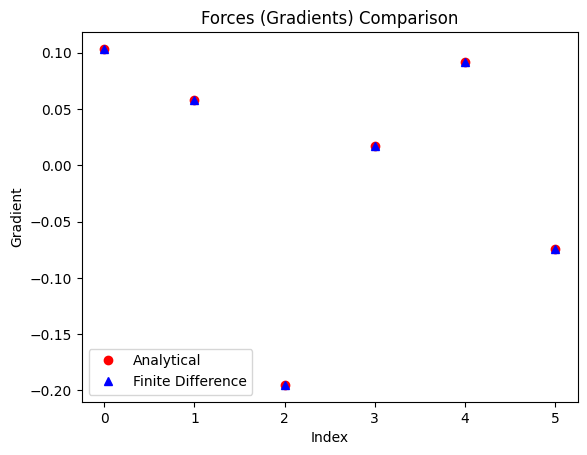

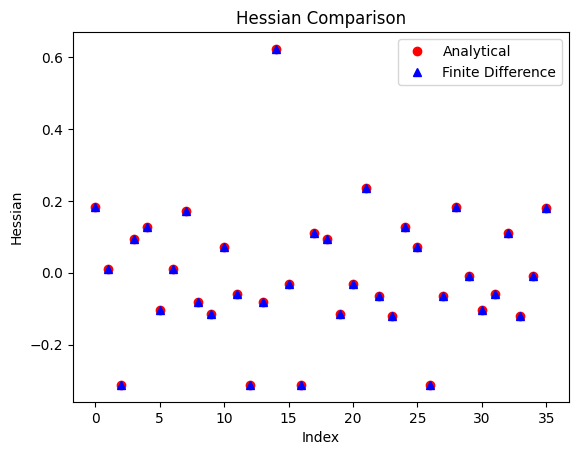

In [ ]:
def test_energy_stretch_linear_elastic():
  '''
  This function tests the outputs (gradient and hessian) of
  grad_and_hess_strain_stretch2D() against their finite difference
  approximations.
  '''

  # Stretching stiffness
  EA = np.random.rand()

  # Undeformed configuration (2 nodes, 1 edge)
  x0 = np.random.rand(6)
  l_0 = np.linalg.norm(x0[0:2] - x0[2:4])
  l_1 = np.linalg.norm(x0[2:4] - x0[4:6])
  l_eff = 0.5 * (l_0 + l_1)

  # Deformed configuration (2 nodes, 1 edge)
  x = np.random.rand(9)
  node0 = x[0:2]
  node1 = x[2:4]
  node2 = x[4:6]

  # Stretching force and Jacobian
  grad, hess = grad_and_hess_energy_stretch_linear_elastic(node0, node1, node2, l_eff, EA)

  # Use FDM to compute Fs and Js
  change = 1e-6
  energy_ground = get_energy_stretch_linear_elastic(node0, node1, node2, l_eff, EA)
  grad_fdm = np.zeros(6)
  hess_fdm = np.zeros((6,6))
  for c in range(6):
    x_plus = x.copy()
    x_plus[c] += change
    node0_plus = x_plus[0:2]
    node1_plus = x_plus[2:4]
    node2_plus = x_plus[4:6]
    energy_plus = get_energy_stretch_linear_elastic(node0_plus, node1_plus, node2_plus, \
                                          l_eff, EA)
    grad_fdm[c] = (energy_plus - energy_ground) / change

    grad_change, _ = grad_and_hess_energy_stretch_linear_elastic(node0_plus, node1_plus, \
                                                  node2_plus, l_eff, EA)
    hess_fdm[:,c] = (grad_change - grad) / change

  # First plot: Forces (Gradients)
  plt.figure(1)  # Equivalent to MATLAB's figure(1)
  plt.plot(grad, 'ro', label='Analytical')  # Plot analytical forces
  plt.plot(grad_fdm, 'b^', label='Finite Difference')  # Plot finite difference forces
  plt.legend(loc='best')  # Display the legend
  plt.xlabel('Index')  # X-axis label
  plt.ylabel('Gradient')  # Y-axis label
  plt.title('Forces (Gradients) Comparison')  # Optional title
  plt.show()  # Show the plot

  # Second plot: Hessians
  plt.figure(2)  # Equivalent to MATLAB's figure(2)
  plt.plot(hess.flatten(), 'ro', label='Analytical')  # Flatten and plot analytical Hessian
  plt.plot(hess_fdm.flatten(), 'b^', label='Finite Difference')  # Flatten and plot finite difference Hessian
  plt.legend(loc='best')  # Display the legend
  plt.xlabel('Index')  # X-axis label
  plt.ylabel('Hessian')  # Y-axis label
  plt.title('Hessian Comparison')  # Optional title
  plt.show()  # Show the plot
  return

test_energy_stretch_linear_elastic()

# Gradient and Hessian of Elastic Energy - Bending Energy in Conventional (Linear Elastic) Formulation

In [ ]:
def get_energy_bending_linear_elastic(node0, node1, node2 = None, l_eff = None, EI = None):
  if node2 is None:
    return 0
  strain_curvature = get_strain_curvature2D(node0, node1, node2)
  E_b = 0.5 * EI / l_eff * strain_curvature**2.0
  return E_b

In [ ]:
def grad_and_hess_energy_bending_linear_elastic(node0, node1, node2 = None, l_eff = None, EI = None):

  if node2 is None:
    return np.zeros(4), np.zeros((4,4))

  strain_curvature = get_strain_curvature2D(node0, node1, node2)
  G_strain, H_strain = grad_and_hess_strain_curvature2D(node0, node1, node2)

  gradE_strain = EI * strain_curvature / l_eff
  hessE_strain = EI / l_eff

  G = gradE_strain * G_strain
  H = gradE_strain * H_strain + hessE_strain * np.outer(G_strain, G_strain)

  return G, H

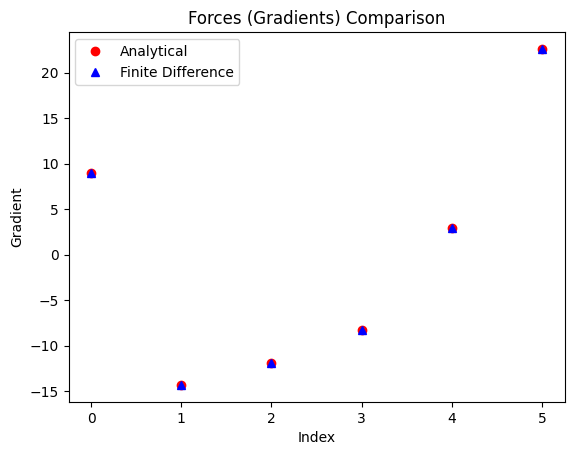

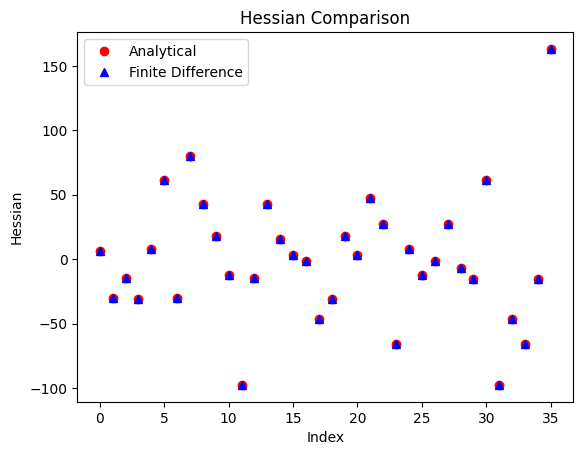

In [ ]:
def test_energy_bending_linear_elastic():
  '''
  This function tests the outputs (gradient and hessian) of
  grad_and_hess_strain_stretch2D() against their finite difference
  approximations.
  '''

  # Bending stiffness
  EI = np.random.rand()

  # Undeformed configuration (2 nodes, 1 edge)
  x0 = np.random.rand(6)
  l_0 = np.linalg.norm(x0[0:2] - x0[2:4])
  l_1 = np.linalg.norm(x0[2:4] - x0[4:6])
  l_eff = 0.5 * (l_0 + l_1)

  # Deformed configuration (2 nodes, 1 edge)
  x = np.random.rand(9)
  node0 = x[0:2]
  node1 = x[2:4]
  node2 = x[4:6]

  # Bending force and Jacobian
  grad, hess = grad_and_hess_energy_bending_linear_elastic(node0, node1, node2, l_eff, EI)

  # Use FDM to compute Fs and Js
  change = 1e-6
  energy_ground = get_energy_bending_linear_elastic(node0, node1, node2, l_eff, EI)
  grad_fdm = np.zeros(6)
  hess_fdm = np.zeros((6,6))
  for c in range(6):
    x_plus = x.copy()
    x_plus[c] += change
    node0_plus = x_plus[0:2]
    node1_plus = x_plus[2:4]
    node2_plus = x_plus[4:6]
    energy_plus = get_energy_bending_linear_elastic(node0_plus, node1_plus, node2_plus, \
                                          l_eff, EI)
    grad_fdm[c] = (energy_plus - energy_ground) / change

    grad_change, _ = grad_and_hess_energy_bending_linear_elastic(node0_plus, node1_plus, \
                                                  node2_plus, l_eff, EI)
    hess_fdm[:,c] = (grad_change - grad) / change

  # First plot: Forces (Gradients)
  plt.figure(1)  # Equivalent to MATLAB's figure(1)
  plt.plot(grad, 'ro', label='Analytical')  # Plot analytical forces
  plt.plot(grad_fdm, 'b^', label='Finite Difference')  # Plot finite difference forces
  plt.legend(loc='best')  # Display the legend
  plt.xlabel('Index')  # X-axis label
  plt.ylabel('Gradient')  # Y-axis label
  plt.title('Forces (Gradients) Comparison')  # Optional title
  plt.show()  # Show the plot

  # Second plot: Hessians
  plt.figure(2)  # Equivalent to MATLAB's figure(2)
  plt.plot(hess.flatten(), 'ro', label='Analytical')  # Flatten and plot analytical Hessian
  plt.plot(hess_fdm.flatten(), 'b^', label='Finite Difference')  # Flatten and plot finite difference Hessian
  plt.legend(loc='best')  # Display the legend
  plt.xlabel('Index')  # X-axis label
  plt.ylabel('Hessian')  # Y-axis label
  plt.title('Hessian Comparison')  # Optional title
  plt.show()  # Show the plot
  return

test_energy_bending_linear_elastic()

# Neural Network Model

**NN approximation of y = x^2**

In [ ]:
class ElasticEnergy(nn.Module):
    def __init__(self):
        super(ElasticEnergy, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 16, dtype=torch.float64),  # Initialize with float64
            nn.Tanh(),
            nn.Linear(16, 16, dtype=torch.float64),
            nn.Tanh(),
            nn.Linear(16, 1, dtype=torch.float64),
        )

    def forward(self, x):
        return self.layers(x)

    def compute_energy_grad_hess(self, x):
        """
        Compute energy, gradient, and Hessian with respect to the input.

        Parameters:
            x (float): Input value.

        Returns:
            tuple: (energy, gradient, Hessian), where:
                - energy (float): Energy at the input.
                - gradient (float): dE/dx at the input.
                - Hessian (float): d²E/dx² at the input.
        """
        # Create a tensor for the input
        x_tensor = torch.tensor([[x]], requires_grad=True, dtype=torch.float64)

        # Forward pass to compute energy
        energy = self.forward(x_tensor)

        # Compute gradient (dE/dx)
        if x_tensor.grad is not None:
            x_tensor.grad.zero_()  # Clear existing gradients
        energy.backward(retain_graph=True)
        gradient = x_tensor.grad.item()

        # Compute Hessian (d²E/dx²)
        grad_tensor = torch.autograd.grad(energy, x_tensor, create_graph=True)[0]
        hessian = torch.autograd.grad(grad_tensor, x_tensor, retain_graph=True)[0].item()

        return energy.item(), gradient, hessian

**Train the energy**

Epoch [1000/10000], Loss: 0.0094
Epoch [2000/10000], Loss: 0.0015
Epoch [3000/10000], Loss: 0.0007
Epoch [4000/10000], Loss: 0.0005
Epoch [5000/10000], Loss: 0.0004
Epoch [6000/10000], Loss: 0.0004
Epoch [7000/10000], Loss: 0.0004
Epoch [8000/10000], Loss: 0.0002
Epoch [9000/10000], Loss: 0.0001
Epoch [10000/10000], Loss: 0.0033


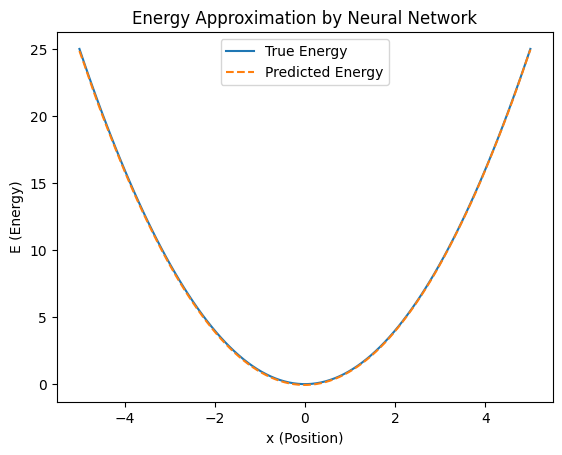

In [ ]:
# Generate training data
x_train = np.linspace(-5, 5, 100).reshape(-1, 1)  # Inputs (positions)
E_train = x_train**2                    # Outputs (energies)

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float64)
E_train_tensor = torch.tensor(E_train, dtype=torch.float64)

# Instantiate the model
energy_model = ElasticEnergy()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(energy_model.parameters(), lr=0.01)

# Training loop
epochs = 10000
for epoch in range(epochs):
    # Forward pass
    predictions = energy_model(x_train_tensor)
    loss = criterion(predictions, E_train_tensor)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

# Generate predictions
x_test = np.linspace(-5, 5, 100).reshape(-1, 1)
x_test_tensor = torch.tensor(x_test, dtype=torch.float64)
E_pred = energy_model(x_test_tensor).detach().numpy()

# Plot the true and predicted energies
plt.figure()
plt.plot(x_test, x_test**2, label='True Energy')
plt.plot(x_test, E_pred, label='Predicted Energy', linestyle='--')
plt.xlabel('x (Position)')
plt.ylabel('E (Energy)')
plt.legend()
plt.title('Energy Approximation by Neural Network')
plt.show()

# torch.save(energy_model, "energy_model_complete.pth")

**FDM Validation**

x = -1.0
Energy (Analytical): 0.9278690178289752
Gradient (Analytical): -1.9778193194058233, Gradient (FDM): -1.9778193193875635
Hessian (Analytical): 1.9666691569518076, Hessian (FDM): 1.9666691569719672
--------------------------------------------------
x = -0.5
Energy (Analytical): 0.1847105024153135
Gradient (Analytical): -0.9931189127380089, Gradient (FDM): -0.9931189127287964
Hessian (Analytical): 1.9858295748313095, Hessian (FDM): 1.9858295748242936
--------------------------------------------------
x = 0.0
Energy (Analytical): -0.06141740954951547
Gradient (Analytical): 0.012324734468896592, Gradient (FDM): 0.01232473449963578
Hessian (Analytical): 2.027779489190767, Hessian (FDM): 2.0277794891887524
--------------------------------------------------
x = 0.5
Energy (Analytical): 0.19714227272239593
Gradient (Analytical): 1.0174017585319457, Gradient (FDM): 1.017401758507397
Hessian (Analytical): 1.9755948653174604, Hessian (FDM): 1.9755948652999675
-----------------------------

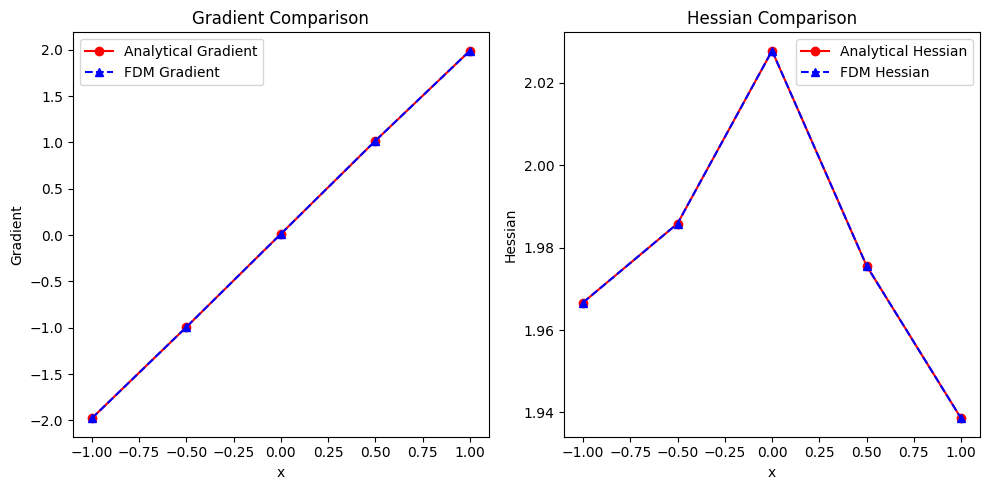

In [ ]:
# Test function using FDM
def validate_energy_grad_hess(energy_model, x_value, delta=1e-5):
    """
    Validate the gradient and Hessian computed by the model using finite difference.

    Parameters:
        energy_model (ElasticEnergy): The neural network model.
        x_value (float): The input value for which to validate.
        delta (float): Small perturbation for finite difference.

    Returns:
        dict: Results containing analytical and FDM values for energy, gradient, and Hessian.
    """
    # Compute analytical results
    energy, grad_analytical, hess_analytical = energy_model.compute_energy_grad_hess(x_value)

    # Finite difference for gradient
    energy_plus = energy_model.compute_energy_grad_hess(x_value + delta)[0]
    energy_minus = energy_model.compute_energy_grad_hess(x_value - delta)[0]
    grad_fdm = (energy_plus - energy_minus) / (2 * delta)

    # Finite difference for Hessian
    grad_plus = (energy_model.compute_energy_grad_hess(x_value + delta)[1])
    grad_minus = (energy_model.compute_energy_grad_hess(x_value - delta)[1])
    hess_fdm = (grad_plus - grad_minus) / (2 * delta)

    # Return results
    results = {
        "x_value": x_value,
        "energy_analytical": energy,
        "grad_analytical": grad_analytical,
        "hess_analytical": hess_analytical,
        "grad_fdm": grad_fdm,
        "hess_fdm": hess_fdm
    }
    return results


# Test inputs
x_values = np.linspace(-1, 1, 5)  # Test over a range of inputs
results = []

for x in x_values:
    res = validate_energy_grad_hess(energy_model, x)
    results.append(res)
    print(f"x = {x}")
    print(f"Energy (Analytical): {res['energy_analytical']}")
    print(f"Gradient (Analytical): {res['grad_analytical']}, Gradient (FDM): {res['grad_fdm']}")
    print(f"Hessian (Analytical): {res['hess_analytical']}, Hessian (FDM): {res['hess_fdm']}")
    print("-" * 50)

# Visualization
analytical_grad = [res["grad_analytical"] for res in results]
fdm_grad = [res["grad_fdm"] for res in results]
analytical_hess = [res["hess_analytical"] for res in results]
fdm_hess = [res["hess_fdm"] for res in results]

plt.figure(figsize=(10, 5))

# Gradient Comparison
plt.subplot(1, 2, 1)
plt.plot(x_values, analytical_grad, 'ro-', label='Analytical Gradient')
plt.plot(x_values, fdm_grad, 'b^--', label='FDM Gradient')
plt.xlabel("x")
plt.ylabel("Gradient")
plt.title("Gradient Comparison")
plt.legend()

# Hessian Comparison
plt.subplot(1, 2, 2)
plt.plot(x_values, analytical_hess, 'ro-', label='Analytical Hessian')
plt.plot(x_values, fdm_hess, 'b^--', label='FDM Hessian')
plt.xlabel("x")
plt.ylabel("Hessian")
plt.title("Hessian Comparison")
plt.legend()

plt.tight_layout()
plt.show()

# Neural Network Model: Comprehensive for 2D beams

$$
E = \frac{1}{2} EA \Delta l \varepsilon^2
+ \frac{1}{2} \frac{EI}{\Delta l} \kappa^2
$$
where $EI = Y \pi h^4/4$ and $EA = Y \pi h^2$. Here, $h$ is the cross-sectional radius and $Y$ is the Young's modulus.

We can rewrite the above equations as
$$
E = \frac{1}{2} EA \Delta l
\left( \varepsilon^2
+ \frac{1}{4} \bar{\kappa}^2
\right),
$$
where $\bar{\kappa} = \kappa h / \Delta l$.



In [ ]:
# Define the custom SquareActivation function
class SquareActivation(nn.Module):
    def forward(self, x):
        return x**2

class ElasticEnergyGeneric(nn.Module):
    def __init__(self):
        super(ElasticEnergyGeneric, self).__init__()
        self.layers = nn.Sequential(
            SquareActivation(),
            nn.Linear(2, 4, dtype=torch.float64),  # Initialize with float64
            nn.ReLU(),
            nn.Linear(4, 4, dtype=torch.float64),
            nn.ReLU(),
            nn.Linear(4, 1, dtype=torch.float64),
        )

    def forward(self, x):
        return self.layers(x)

    def compute_energy_grad_hess(self, x):
        """
        Compute energy, gradient, and Hessian with respect to the input.

        Parameters:
            x (numpy.ndarray): Input vector (2D), shape (2,).

        Returns:
            tuple: (energy, gradient, Hessian), where:
                - energy (float): Energy at the input.
                - gradient (numpy.ndarray): Gradient vector, shape (2,).
                - Hessian (numpy.ndarray): Hessian matrix, shape (2, 2).
        """

        # Ensure the input is a 2D tensor of shape (1, 2)
        if isinstance(x, torch.Tensor):
            x_tensor = x.clone().detach().reshape(1, -1).requires_grad_(True)  # Safely copy the tensor
        else:
            x_tensor = torch.tensor(x.reshape(1, -1), requires_grad=True, dtype=torch.float64)

        # Forward pass to compute energy (output is scalar)
        energy = self.forward(x_tensor).squeeze()  # Remove batch dimension, if any

        # Compute gradient (dE/dx)
        grad = torch.autograd.grad(energy, x_tensor, create_graph=True)[0].squeeze()  # Shape: (2,)

        # Compute Hessian (d²E/dx²)
        hess = torch.zeros((2, 2), dtype=torch.float64)  # Initialize Hessian
        for i in range(2):  # Iterate over each dimension
            grad_i = torch.autograd.grad(grad[i], x_tensor, retain_graph=True)[0].squeeze()  # Shape: (2,)
            hess[i, :] = grad_i  # Fill row i of the Hessian

        return energy.item(), grad.detach().numpy(), hess.detach().numpy()

In [ ]:
def train_elastic_energy_generic_model(model, x_train, y_train, E_train, epochs=10000, lr=0.01, verbose=True):
    """
    Train the ElasticEnergyGeneric model to approximate the energy function.

    Parameters:
        model (nn.Module): The neural network model to train.
        x_train (numpy.ndarray): Training inputs (x-coordinates), shape (n_samples, 1).
        y_train (numpy.ndarray): Training inputs (y-coordinates), shape (n_samples, 1).
        E_train (numpy.ndarray): Training outputs (energies), shape (n_samples, 1).
        epochs (int): Number of training epochs.
        lr (float): Learning rate for the optimizer.
        verbose (bool): Whether to print training progress.

    Returns:
        model (nn.Module): Trained model.
        losses (list): List of loss values for each epoch.
    """
    # Combine x_train and y_train into a single input
    inputs_train = np.hstack((x_train, y_train))  # Shape: (n_samples, 2)

    # Convert training data to PyTorch tensors
    inputs_tensor = torch.tensor(inputs_train, dtype=torch.float64)  # Shape: (n_samples, 2)
    E_train_tensor = torch.tensor(E_train, dtype=torch.float64)      # Shape: (n_samples, 1)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # List to store loss values for plotting
    losses = []

    # Training loop
    for epoch in range(epochs):
        # Forward pass
        predictions = model(inputs_tensor)
        loss = criterion(predictions, E_train_tensor)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save loss for monitoring
        losses.append(loss.item())

        # Print progress
        if verbose and (epoch + 1) % (epochs // 20) == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.6f}')

    return model, losses

Epoch [500/10000], Loss: 0.000130
Epoch [1000/10000], Loss: 0.000116
Epoch [1500/10000], Loss: 0.000103
Epoch [2000/10000], Loss: 0.000090
Epoch [2500/10000], Loss: 0.000079
Epoch [3000/10000], Loss: 0.000069
Epoch [3500/10000], Loss: 0.000059
Epoch [4000/10000], Loss: 0.000050
Epoch [4500/10000], Loss: 0.000041
Epoch [5000/10000], Loss: 0.000032
Epoch [5500/10000], Loss: 0.000025
Epoch [6000/10000], Loss: 0.000018
Epoch [6500/10000], Loss: 0.000013
Epoch [7000/10000], Loss: 0.000009
Epoch [7500/10000], Loss: 0.000006
Epoch [8000/10000], Loss: 0.000004
Epoch [8500/10000], Loss: 0.000002
Epoch [9000/10000], Loss: 0.000002
Epoch [9500/10000], Loss: 0.000001
Epoch [10000/10000], Loss: 0.000000


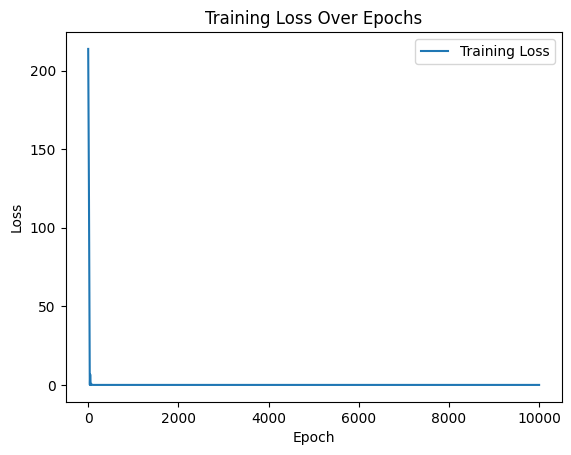

In [ ]:
# Generate training data
x_train = np.linspace(-5, 5, 1000).reshape(-1, 1)  # Inputs (x-coordinates)
y_train = np.linspace(-5, 5, 1000).reshape(-1, 1)  # Inputs (y-coordinates)
E_train = x_train**2 + 0.25 * y_train**2                 # Outputs (energies)

# Instantiate the model
energy_model_generic = ElasticEnergyGeneric()

# Train the model
energy_model_generic, losses = train_elastic_energy_generic_model(
    energy_model_generic, x_train, y_train, E_train, epochs=10000, lr=0.01
)

# Plot training loss
plt.figure()
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
# Test input
# x_input = np.array([1.0, -1.0])  # 2D input vector
x_input = np.random.rand(2)

# Compute energy, gradient, and Hessian
energy, grad, hess = energy_model_generic.compute_energy_grad_hess(x_input)

print(f'x = {x_input[0]} and {x_input[1]}')
print("Energy:", energy)        # Scalar
print("Gradient:", grad)        # 2x1 vector
print("Hessian:\n", hess)       # 2x2 matrix

x = 0.27230489765106847 and 0.46230977235684834
Energy: 0.21519334818903638
Gradient: [0.22209338 0.79105191]
Hessian:
 [[0.81560554 0.        ]
 [0.         1.71108629]]


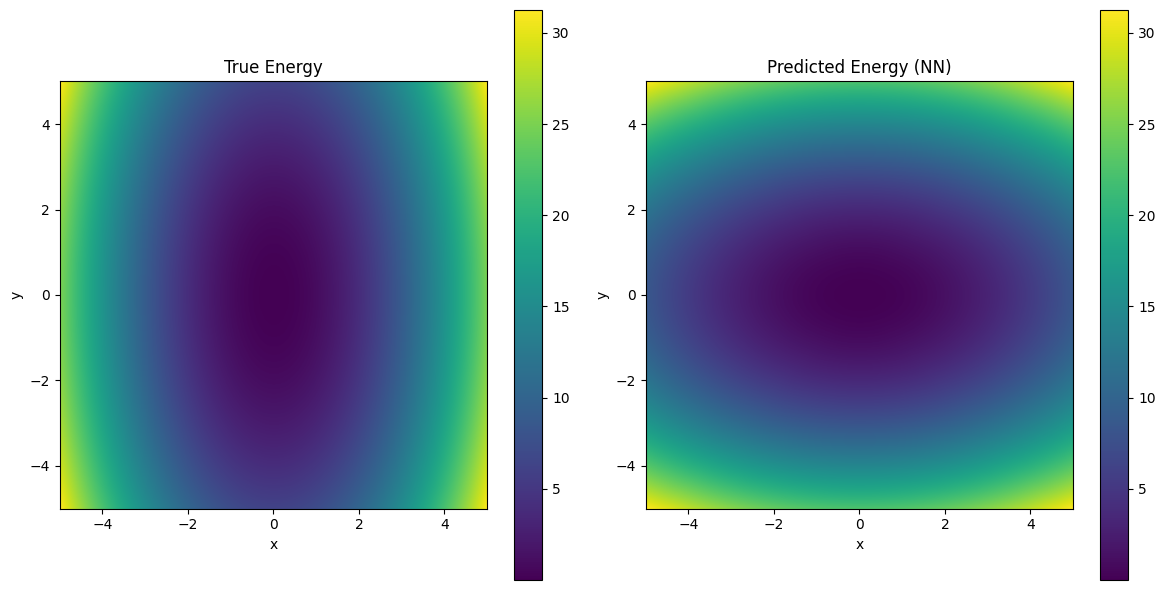

In [ ]:
# Generate test data
x_test = np.linspace(-5, 5, 500)
y_test = np.linspace(-5, 5, 500)
x_grid, y_grid = np.meshgrid(x_test, y_test)

# Flatten the grid for input into NN
input_data = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

# Convert to PyTorch tensor
input_tensor = torch.tensor(input_data, dtype=torch.float64)

# True function: E(x, y) = x^2 + 0.25*y^2
true_energy = input_data[:, 0]**2 + 0.25 * input_data[:, 1]**2

# NN prediction
with torch.no_grad():
    predicted_energy = energy_model_generic(input_tensor).numpy().flatten()

# Reshape for plotting
true_energy_grid = true_energy.reshape(x_grid.shape)
predicted_energy_grid = predicted_energy.reshape(x_grid.shape)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# True energy
im1 = axes[0].imshow(
    true_energy_grid, extent=[-5, 5, -5, 5], origin="lower", cmap="viridis"
)
axes[0].set_title("True Energy")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
fig.colorbar(im1, ax=axes[0])

# Predicted energy
im2 = axes[1].imshow(
    predicted_energy_grid, extent=[-5, 5, -5, 5], origin="lower", cmap="viridis"
)
axes[1].set_title("Predicted Energy (NN)")
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")
fig.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

# Gradient and Hessian of Elastic Energy - Stretching Energy in NN-based (Linear Elastic) Formulation

In [ ]:
def get_energy_stretch_nn(node0, node1, node2=None, l_eff=None, EA=None, nn_model=None):
    """
    Compute the energy using the NN-based solution for strain stretch.

    Parameters:
        node0 (array-like): Coordinates of node 0.
        node1 (array-like): Coordinates of node 1.
        node2 (array-like, optional): Coordinates of node 2.
        l_eff (float): Effective length.
        EA (float): Axial stiffness (Young's modulus * Area).
        nn_model (ElasticEnergy): Trained neural network for energy computation.

    Returns:
        float: Energy computed using the NN-based solution.
    """
    # Compute strain stretch using the existing function
    strain_stretch = get_strain_stretch2D(node0, node1, node2, l_eff, l_eff)

    # Use the NN model to compute energy instead of strain_stretch**2.0
    strain_tensor = torch.tensor([[strain_stretch]], dtype=torch.float64)
    nn_energy_output = nn_model.forward(strain_tensor).item()
    # nn_energy_output, grad, hess = nn_model.compute_energy_grad_hess(strain_tensor)

    # Scale by EA and l_eff as in the original function
    E_s = 0.5 * EA * nn_energy_output * l_eff
    return E_s

In [ ]:
def grad_and_hess_energy_stretch_nn(node0, node1, node2 = None, l_eff = None, EA = None, nn_model=None):

    strain_stretch = get_strain_stretch2D(node0, node1, node2, l_eff, l_eff) # Geometry, no ML
    G_strain, H_strain = grad_and_hess_strain_stretch2D(node0, node1, node2, l_eff, l_eff) # Geometry, no ML

    # Use NN module
    strain_tensor = torch.tensor([[strain_stretch]], dtype=torch.float64)
    _, gradE_strain, hessE_strain = nn_model.compute_energy_grad_hess(strain_tensor)

    # Scale
    gradE_strain = (0.5 * EA * l_eff) * gradE_strain
    hessE_strain = (0.5 * EA * l_eff) * hessE_strain

    G = gradE_strain * G_strain
    H = gradE_strain * H_strain + hessE_strain * np.outer(G_strain, G_strain)

    return G, H

In [ ]:
# Define input values for evaluation
x_values = [0.1, 1.0]

# Evaluate and print gradient and Hessian for each input
for x in x_values:
    energy, grad, hess = energy_model.compute_energy_grad_hess(x)
    print(f"x = {x}")
    print(f"Energy (E): {energy}")
    print(f"Gradient (dE/dx): {grad}")
    print(f"Hessian (d²E/dx²): {hess}")

x = 0.1
Energy (E): -0.05004644208822895
Gradient (dE/dx): 0.21506999400613203
Hessian (d²E/dx²): 2.026295641117421
x = 1.0
Energy (E): 0.9497266782873022
Gradient (dE/dx): 1.9894621253755438
Hessian (d²E/dx²): 1.9385717953461659


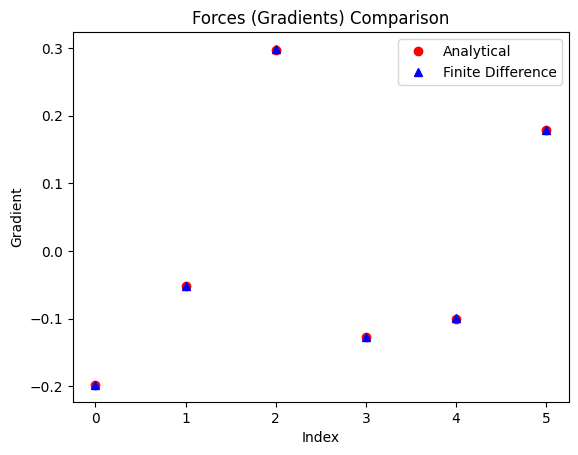

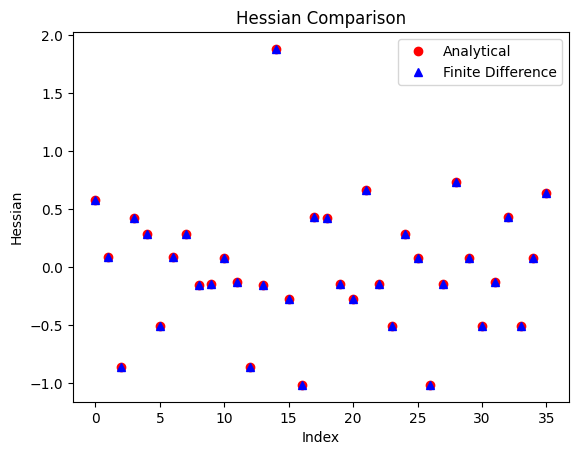

In [ ]:
def test_energy_stretch_nn():
  '''
  This function tests the outputs (gradient and hessian) of
  grad_and_hess_energy_stretch_nn() against their finite difference
  approximations.
  '''

  # Stretching stiffness
  EA = np.random.rand()

  # Undeformed configuration (2 nodes, 1 edge)
  x0 = np.random.rand(6)
  l_0 = np.linalg.norm(x0[0:2] - x0[2:4])
  l_1 = np.linalg.norm(x0[2:4] - x0[4:6])
  l_eff = 0.5 * (l_0 + l_1)

  # Deformed configuration (2 nodes, 1 edge)
  x = np.random.rand(6)
  node0 = x[0:2]
  node1 = x[2:4]
  node2 = x[4:6]

  # Stretching force and Jacobian
  grad, hess = grad_and_hess_energy_stretch_nn(node0, node1, node2, l_eff, EA, energy_model)

  # Use FDM to compute Fs and Js
  change = 1e-3
  # change = np.sqrt(np.finfo(float).eps)  # Optimal perturbation size
  energy_ground = get_energy_stretch_nn(node0, node1, node2, l_eff, EA, energy_model)
  grad_fdm = np.zeros(6)
  hess_fdm = np.zeros((6,6))
  for c in range(6):
    x_plus = x.copy()
    x_plus[c] += change
    node0_plus = x_plus[0:2]
    node1_plus = x_plus[2:4]
    node2_plus = x_plus[4:6]
    energy_plus = get_energy_stretch_nn(node0_plus, node1_plus, node2_plus, \
                                          l_eff, EA, energy_model)
    grad_fdm[c] = (energy_plus - energy_ground) / change

    grad_change, _ = grad_and_hess_energy_stretch_nn(node0_plus, node1_plus, \
                                                  node2_plus, l_eff, EA, energy_model)
    hess_fdm[:,c] = (grad_change - grad) / change

  # First plot: Forces (Gradients)
  plt.figure(1)  # Equivalent to MATLAB's figure(1)
  plt.plot(grad, 'ro', label='Analytical')  # Plot analytical forces
  plt.plot(grad_fdm, 'b^', label='Finite Difference')  # Plot finite difference forces
  plt.legend(loc='best')  # Display the legend
  plt.xlabel('Index')  # X-axis label
  plt.ylabel('Gradient')  # Y-axis label
  plt.title('Forces (Gradients) Comparison')  # Optional title
  plt.show()  # Show the plot

  # Second plot: Hessians
  plt.figure(2)  # Equivalent to MATLAB's figure(2)
  plt.plot(hess.flatten(), 'ro', label='Analytical')  # Flatten and plot analytical Hessian
  plt.plot(hess_fdm.flatten(), 'b^', label='Finite Difference')  # Flatten and plot finite difference Hessian
  plt.legend(loc='best')  # Display the legend
  plt.xlabel('Index')  # X-axis label
  plt.ylabel('Hessian')  # Y-axis label
  plt.title('Hessian Comparison')  # Optional title
  plt.show()  # Show the plot
  return

test_energy_stretch_nn()

**Compare with analytical solution**

In [ ]:
# Example nodes
node0 = [0.0, 0.0]
node1 = [1.0, 0.1]
node2 = [2.0, 0.3]

# Parameters
l_eff = 2.0
EA = 100.0
# Compare outputs of both functions
energy_linear = get_energy_stretch_linear_elastic(node0, node1, node2, l_eff, EA)
energy_nn = get_energy_stretch_nn(node0, node1, node2, l_eff, EA, energy_model)

print(f"Linear Elastic Energy: {energy_linear}")
print(f"NN-Based Energy: {energy_nn}")

Linear Elastic Energy: 24.38405473378666
NN-Based Energy: 17.85934298553482


# Gradient and Hessian of Elastic Energy - Bending Energy in NN-based (Linear Elastic) Formulation

In [ ]:
def get_energy_bending_nn(node0, node1, node2 = None, l_eff = None, EA = None, h = None, nn_model=None):

  if node2 is None:
    return 0

  # Get curvature given three nodes
  strain_curvature = get_strain_curvature2D(node0, node1, node2)

  # Scale strain before passing onto the nn_model
  strain_curvature = strain_curvature / l_eff * h
  strain_tensor = torch.tensor([[strain_curvature]], dtype=torch.float64)

  nn_energy_output = nn_model.forward(strain_tensor).item()

  E_b = (0.5 * 0.25 * EA * l_eff) * nn_energy_output
  # Note that EI / EA = 1/4 * h^2.
  # Eb = 0.5 * EI / l_eff * kappa^2 = (0.5 * 0.25 * EA * l_eff) * (kappa*h/l_eff)^2
  return E_b

In [ ]:
def grad_and_hess_energy_bending_nn(node0, node1, node2 = None, l_eff = None, EA = None, h = None, nn_model=None):

  if node2 is None:
    return 0, 0

  strain_curvature = get_strain_curvature2D(node0, node1, node2)
  G_strain, H_strain = grad_and_hess_strain_curvature2D(node0, node1, node2)

  # Use NN module
  # Scale strain before passing onto the nn_model
  strain_curvature = strain_curvature / l_eff * h
  strain_tensor = torch.tensor([[strain_curvature]], dtype=torch.float64)
  _, gradE_strain, hessE_strain = nn_model.compute_energy_grad_hess(strain_tensor)
  # Scale back
  gradE_strain = gradE_strain * h / l_eff
  hessE_strain = hessE_strain * h**2 / l_eff**2

  G = gradE_strain * G_strain
  H = gradE_strain * H_strain + hessE_strain * np.outer(G_strain, G_strain)

  G = (0.5 * 0.25 * EA * l_eff) * G
  H = (0.5 * 0.25 * EA * l_eff) * H

  return G, H

Analytical Gradient: [-1.23567813e-03 -3.19130973e-05 -4.03550094e-04 -5.50009159e-04
  1.63922822e-03  5.81922257e-04]
Finite Difference Gradient: [-1.22884589e-03 -3.18715822e-05 -4.01960782e-04 -5.49498936e-04
  1.65236132e-03  5.82558980e-04]


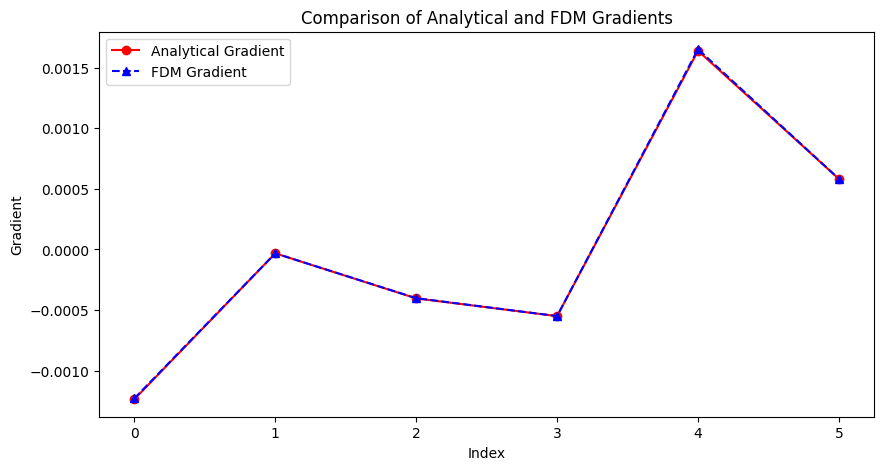

In [ ]:
# Parameters
EA = np.random.rand()  # Stretching stiffness
h = 0.01               # Radius

# Undeformed configuration (2 nodes, 1 edge)
x0 = np.random.rand(6)
l_0 = np.linalg.norm(x0[0:2] - x0[2:4])
l_1 = np.linalg.norm(x0[2:4] - x0[4:6])
l_eff = 0.5 * (l_0 + l_1)

# Deformed configuration (2 nodes, 1 edge)
x = np.random.rand(6)
node0 = x[0:2]
node1 = x[2:4]
node2 = x[4:6]

# Analytical gradient and Hessian
grad, hess = grad_and_hess_energy_bending_nn(node0, node1, node2, l_eff, EA, h, energy_model)

# Finite difference method
perturbation = 1e-3
energy_original = get_energy_bending_nn(node0, node1, node2, l_eff, EA, h, energy_model)

grad_fdm = np.zeros(6)
for c in range(len(x)):
    x_perturbed = x.copy()
    x_perturbed[c] += perturbation
    node0_perturbed = x_perturbed[0:2]
    node1_perturbed = x_perturbed[2:4]
    node2_perturbed = x_perturbed[4:6]
    energy_perturbed = get_energy_bending_nn(node0_perturbed, node1_perturbed, node2_perturbed, l_eff, EA, h, energy_model)
    grad_fdm[c] = (energy_perturbed - energy_original) / perturbation

# Results comparison
print("Analytical Gradient:", grad)
print("Finite Difference Gradient:", grad_fdm)

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(grad, 'ro-', label='Analytical Gradient')
plt.plot(grad_fdm, 'b^--', label='FDM Gradient')
plt.xlabel("Index")
plt.ylabel("Gradient")
plt.legend()
plt.title("Comparison of Analytical and FDM Gradients")
plt.show()

In [ ]:
# Example nodes
node0 = [0.0, 0.0]
node1 = [1.0, 0.0]
node2 = [2.0, 1.0]

# Parameters
Y = 5.0 # Young's Modulus
h = 1.0
l_eff = 2.0
EA = Y * np.pi * h**2
EI = Y * np.pi * h**4 / 4.0

# Compare outputs of both functions
energy_linear = get_energy_bending_linear_elastic(node0, node1, node2, l_eff, EI)
energy_nn = get_energy_bending_nn(node0, node1, node2, l_eff, EA, h, energy_model)

print(f"Linear Elastic Energy: {energy_linear}")
print(f"NN-Based Energy: {energy_nn}")

Linear Elastic Energy: 0.673765105565809
NN-Based Energy: 0.4600519479067172


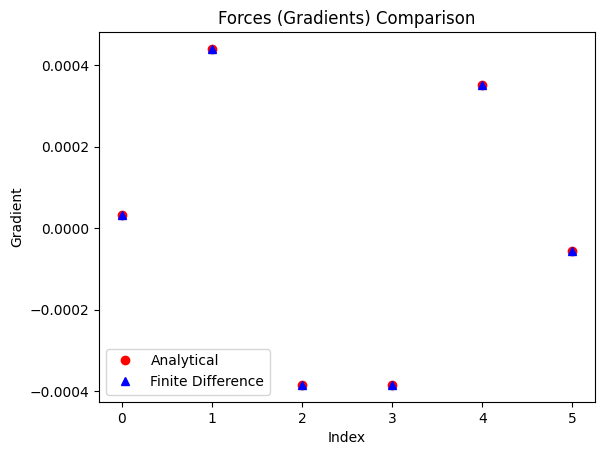

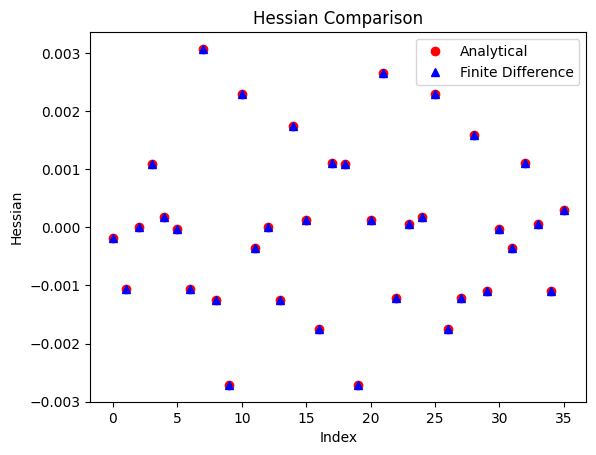

In [ ]:
def test_energy_bending_nn():
  '''
  This function tests the outputs (gradient and hessian) of
  grad_and_hess_energy_stretch_nn() against their finite difference
  approximations.
  '''

  # Stretching stiffness
  EA = np.random.rand()
  # Radius
  h = 0.01

  # Undeformed configuration (2 nodes, 1 edge)
  x0 = np.random.rand(6)
  l_0 = np.linalg.norm(x0[0:2] - x0[2:4])
  l_1 = np.linalg.norm(x0[2:4] - x0[4:6])
  l_eff = 0.5 * (l_0 + l_1)

  # Deformed configuration (2 nodes, 1 edge)
  x = np.random.rand(6)
  node0 = x[0:2]
  node1 = x[2:4]
  node2 = x[4:6]

  # Stretching force and Jacobian
  grad, hess = grad_and_hess_energy_bending_nn(node0, node1, node2, l_eff, EA, h, energy_model)

  # Use FDM to compute Fs and Js
  change = 1e-6
  # change = np.sqrt(np.finfo(float).eps)  # Optimal perturbation size
  energy_ground = get_energy_bending_nn(node0, node1, node2, l_eff, EA, h, energy_model)
  grad_fdm = np.zeros(6)
  hess_fdm = np.zeros((6,6))
  for c in range(6):
    x_plus = x.copy()
    x_plus[c] += change
    node0_plus = x_plus[0:2]
    node1_plus = x_plus[2:4]
    node2_plus = x_plus[4:6]
    energy_plus = get_energy_bending_nn(node0_plus, node1_plus, node2_plus, \
                                          l_eff, EA, h, energy_model)
    grad_fdm[c] = (energy_plus - energy_ground) / change

    grad_change, _ = grad_and_hess_energy_bending_nn(node0_plus, node1_plus, \
                                                  node2_plus, l_eff, EA, h, energy_model)
    hess_fdm[:,c] = (grad_change - grad) / change

  # First plot: Forces (Gradients)
  plt.figure(1)  # Equivalent to MATLAB's figure(1)
  plt.plot(grad, 'ro', label='Analytical')  # Plot analytical forces
  plt.plot(grad_fdm, 'b^', label='Finite Difference')  # Plot finite difference forces
  plt.legend(loc='best')  # Display the legend
  plt.xlabel('Index')  # X-axis label
  plt.ylabel('Gradient')  # Y-axis label
  plt.title('Forces (Gradients) Comparison')  # Optional title
  plt.show()  # Show the plot

  # Second plot: Hessians
  plt.figure(2)  # Equivalent to MATLAB's figure(2)
  plt.plot(hess.flatten(), 'ro', label='Analytical')  # Flatten and plot analytical Hessian
  plt.plot(hess_fdm.flatten(), 'b^', label='Finite Difference')  # Flatten and plot finite difference Hessian
  plt.legend(loc='best')  # Display the legend
  plt.xlabel('Index')  # X-axis label
  plt.ylabel('Hessian')  # Y-axis label
  plt.title('Hessian Comparison')  # Optional title
  plt.show()  # Show the plot
  return

test_energy_bending_nn()

# Gradient and Hessian of GENERAL Elastic Energy (Bending+Stretching) in NN-based Formulation

In [ ]:
def get_energy_elastic_nn_generic(node0, node1, node2=None, l_eff=None, EA=None, h = None, nn_model_generic=None):
    """
    Compute the energy using the NN-based solution for elastic energy.

    Parameters:
        node0 (array-like): Coordinates of node 0.
        node1 (array-like): Coordinates of node 1.
        node2 (array-like, optional): Coordinates of node 2.
        l_eff (float): Effective length.
        EA (float): Axial stiffness (Young's modulus * Area).
        nn_model (ElasticEnergy): Trained neural network for energy computation.

    Returns:
        float: Energy computed using the NN-based solution.
    """
    # Compute stretch and curvature using the existing function
    strain_stretch = get_strain_stretch2D(node0, node1, node2, l_eff, l_eff)
    strain_curvature = get_strain_curvature2D(node0, node1, node2)
    strain_curvature = strain_curvature / l_eff * h # Scale strain before passing onto the nn_model

    # Use the NN model to compute energy
    strain_tensor = torch.tensor([[strain_stretch, strain_curvature]], dtype=torch.float64)
    nn_energy_output = nn_model_generic(strain_tensor).item()

    # Scale by EA and l_eff as in the original function
    E_elastic = (0.5 * EA * l_eff) * nn_energy_output

    return E_elastic

In [ ]:
def grad_and_hess_energy_elastic_nn_generic(node0, node1, node2 = None, l_eff = None, EA = None, h = None, nn_model_generic=None):

    if node2 is None:
      # Edge case handling with zero curvature and two nodes
      # It should return gradient of size 4 and Hessian of size 4x4
      if node2 is None:
        # Compute stretch and curvature using the existing function
        strain_stretch = get_strain_stretch2D(node0, node1, node2, l_eff, l_eff)
        strain_curvature = 0.0

        # Compute gradient and hessian of strains
        G_strain_stretch, H_strain_stretch = grad_and_hess_strain_stretch2D(node0, node1, node2, l_eff, l_eff)

        # Use NN module
        strain_tensor = torch.tensor([[strain_stretch, strain_curvature]], dtype=torch.float64)
        _, gradE_strain, hessE_strain = nn_model_generic.compute_energy_grad_hess(strain_tensor)

        # Scale
        gradE_strain = (0.5 * EA * l_eff) * gradE_strain
        hessE_strain = (0.5 * EA * l_eff) * hessE_strain

        G = gradE_strain[0] * G_strain_stretch
        H = gradE_strain[0] * H_strain_stretch + \
        hessE_strain[0,0] * np.outer(G_strain_stretch, G_strain_stretch)

      return G, H

    # Compute stretch and curvature using the existing function
    strain_stretch = get_strain_stretch2D(node0, node1, node2, l_eff, l_eff)
    strain_curvature = get_strain_curvature2D(node0, node1, node2)
    strain_curvature = strain_curvature / l_eff * h # Scale strain before passing onto the nn_model

    # Compute gradient and hessian of strains
    G_strain_stretch, H_strain_stretch = grad_and_hess_strain_stretch2D(node0, node1, node2, l_eff, l_eff)
    G_strain_curvature, H_strain_curvature = grad_and_hess_strain_curvature2D(node0, node1, node2)
    # Scale back
    G_strain_curvature = G_strain_curvature * h / l_eff
    H_strain_curvature = H_strain_curvature * h**2 / l_eff**2

    # Use NN module
    strain_tensor = torch.tensor([[strain_stretch, strain_curvature]], dtype=torch.float64)
    _, gradE_strain, hessE_strain = nn_model_generic.compute_energy_grad_hess(strain_tensor)

    # Scale
    gradE_strain = (0.5 * EA * l_eff) * gradE_strain
    hessE_strain = (0.5 * EA * l_eff) * hessE_strain

    G = gradE_strain[0] * G_strain_stretch + gradE_strain[1] * G_strain_curvature
    H = gradE_strain[0] * H_strain_stretch + \
    hessE_strain[0,0] * np.outer(G_strain_stretch, G_strain_stretch) + \
    hessE_strain[0,1] * np.outer(G_strain_stretch, G_strain_curvature) + \
    gradE_strain[1] * H_strain_curvature + \
    hessE_strain[1,1] * np.outer(G_strain_curvature, G_strain_curvature) + \
    hessE_strain[1,0] * np.outer(G_strain_curvature, G_strain_stretch)

    return G, H

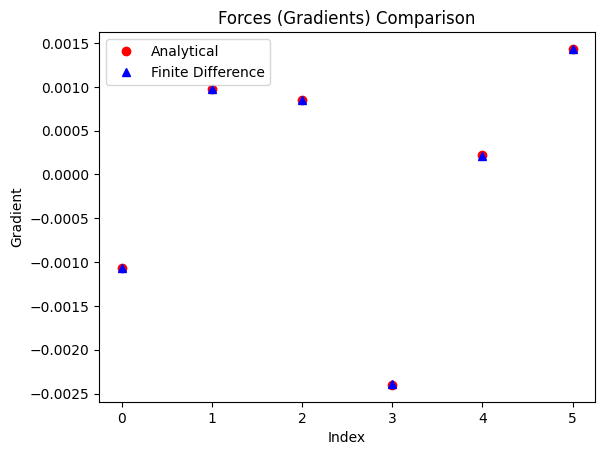

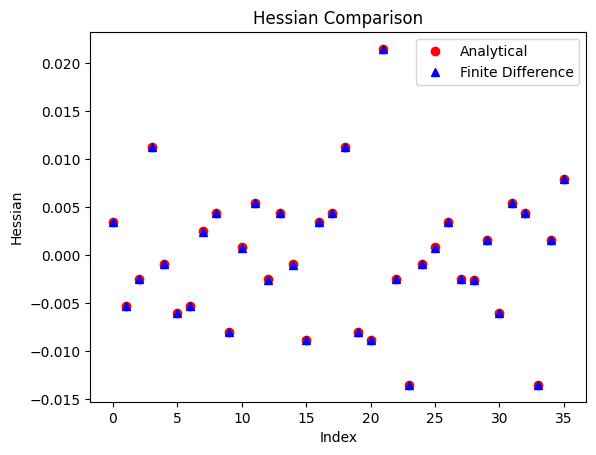

In [ ]:
def test_energy_elastic_nn_generic():
  '''
  This function tests the outputs (gradient and hessian) of
  grad_and_hess_energy_stretch_nn() against their finite difference
  approximations.
  '''

  # Stretching stiffness
  EA = np.random.rand()

  # Undeformed configuration (2 nodes, 1 edge)
  x0 = np.random.rand(6)
  l_0 = np.linalg.norm(x0[0:2] - x0[2:4])
  l_1 = np.linalg.norm(x0[2:4] - x0[4:6])
  l_eff = 0.5 * (l_0 + l_1)

  h = 0.001 # radius

  # Deformed configuration (2 nodes, 1 edge)
  x = np.random.rand(6)
  node0 = x[0:2]
  node1 = x[2:4]
  node2 = x[4:6]

  # Force and Jacobian
  grad, hess = grad_and_hess_energy_elastic_nn_generic(node0, node1, node2, l_eff, EA, h, energy_model_generic)

  # Use FDM to compute Fs and Js
  change = 1e-3
  # change = np.sqrt(np.finfo(float).eps)  # Optimal perturbation size
  energy_ground = get_energy_elastic_nn_generic(node0, node1, node2, l_eff, EA, h, energy_model_generic)
  grad_fdm = np.zeros(6)
  hess_fdm = np.zeros((6,6))
  for c in range(6):
    x_plus = x.copy()
    x_plus[c] += change
    node0_plus = x_plus[0:2]
    node1_plus = x_plus[2:4]
    node2_plus = x_plus[4:6]
    energy_plus = get_energy_elastic_nn_generic(node0_plus, node1_plus, node2_plus, \
                                          l_eff, EA, h, energy_model_generic)
    grad_fdm[c] = (energy_plus - energy_ground) / change

    grad_change, _ = grad_and_hess_energy_elastic_nn_generic(node0_plus, node1_plus, \
                                                  node2_plus, l_eff, EA, h, energy_model_generic)
    hess_fdm[:,c] = (grad_change - grad) / change

  # First plot: Forces (Gradients)
  plt.figure(1)  # Equivalent to MATLAB's figure(1)
  plt.plot(grad, 'ro', label='Analytical')  # Plot analytical forces
  plt.plot(grad_fdm, 'b^', label='Finite Difference')  # Plot finite difference forces
  plt.legend(loc='best')  # Display the legend
  plt.xlabel('Index')  # X-axis label
  plt.ylabel('Gradient')  # Y-axis label
  plt.title('Forces (Gradients) Comparison')  # Optional title
  plt.show()  # Show the plot

  # Second plot: Hessians
  plt.figure(2)  # Equivalent to MATLAB's figure(2)
  plt.plot(hess.flatten(), 'ro', label='Analytical')  # Flatten and plot analytical Hessian
  plt.plot(hess_fdm.flatten(), 'b^', label='Finite Difference')  # Flatten and plot finite difference Hessian
  plt.legend(loc='best')  # Display the legend
  plt.xlabel('Index')  # X-axis label
  plt.ylabel('Hessian')  # Y-axis label
  plt.title('Hessian Comparison')  # Optional title
  plt.show()  # Show the plot
  return

test_energy_elastic_nn_generic()

# Compute the elastic force, given the DOF vector

In [ ]:
class ElasticForce():
  def __init__(self, l_eff_vector, EA, EI = 1.0, h = 1.0, model_choice = 1, nn_model = None):
    self.l_eff_vector = l_eff_vector
    self.EA = EA
    self.EI = EI
    self.h = h
    self.N = len( l_eff_vector ) # Number of nodes
    self.ndof = int(self.N * 2) # Number of DOFs
    self.model_choice = model_choice # 1 for linear elastic, 2 for NN
    self.nn_model = nn_model

  def computeGradientHessian(self, q):
    G = np.zeros( self.ndof )
    H = np.zeros( (self.ndof, self.ndof) )

    for i in range( self.N ):
      l_eff = self.l_eff_vector[i]

      if i == 0:
        node0 = q[2*i:2*i+2]
        node1 = q[2*i+2:2*i+4]
        node2 = None
        ind = np.array([2*i, 2*i+1, 2*i+2, 2*i+3])
      elif i == self.N - 1:
        node0 = q[2*i-2:2*i  ]
        node1 = q[2*i  :2*i+2]
        node2 = None
        ind = np.array([2*i-2, 2*i-1, 2*i, 2*i+1])
      else:
        node0 = q[2*i-2:2*i  ]
        node1 = q[2*i  :2*i+2]
        node2 = q[2*i+2:2*i+4]
        ind = np.array([2*i-2, 2*i-1, 2*i, 2*i+1,2*i+2, 2*i+3])

      if self.model_choice == 1: # Linear Elastic
        dG1, dH1 = grad_and_hess_energy_stretch_linear_elastic(node0, node1, node2, l_eff, self.EA)
        dG2, dH2 = grad_and_hess_energy_bending_linear_elastic(node0, node1, node2, l_eff, self.EI)
        dG = dG1 + dG2
        dH = dH1 + dH2
      elif self.model_choice == 2: # NN-based (separable and simplified)
        dG1, dH1 = grad_and_hess_energy_stretch_nn(node0, node1, node2, l_eff, self.EA, self.nn_model)
        dG2, dH2 = grad_and_hess_energy_bending_nn(node0, node1, node2, l_eff, self.EA, self.h, self.nn_model)
        dG = dG1 + dG2
        dH = dH1 + dH2
      else: # NN-based GENERIC (allows coupling between stretching and bending)
        dG, dH = grad_and_hess_energy_elastic_nn_generic(node0, node1, node2, l_eff, self.EA, self.h, self.nn_model)

      G[ind] = G[ind] + dG
      H[np.ix_(ind, ind)] = H[np.ix_(ind, ind)] + dH

    return G, H

In [ ]:
def computeReferenceLength(q):
  ndof = len( q )
  N = ndof // 2
  l_eff_vector = np.zeros(N)
  for i in range( N):
    if i == 0:
      node0 = q[2*i:2*i+2]
      node1 = q[2*i+2:2*i+4]
      l_eff_vector[i] = np.linalg.norm(node0 - node1)
    elif i == N - 1:
      node0 = q[2*i-2: 2*i]
      node1 = q[2*i  : 2*i+2]
      l_eff_vector[i] = np.linalg.norm(node0 - node1)
    else:
      node0 = q[2*i-2:2*i]
      node1 = q[2*i:2*i+2]
      node2 = q[2*i+2:2*i+4]
      l_eff_vector[i] = 0.5 * (np.linalg.norm(node0 - node1) + np.linalg.norm(node1 - node2))

  return l_eff_vector

In [ ]:
def test_ElasticForce():
  # Define a test q vector (4 nodes with 2 DOFs each)
  q = np.array([0.0, 0.0,   # Node 0
    1.0, 0.0,   # Node 1
    2.0, 0.0,   # Node 2
    3.0, 0.0])  # Node 3
  l_eff_vector = computeReferenceLength(q)
  print(l_eff_vector)

  Y = 5.0
  h = 0.01
  EA = Y * np.pi * h**2.0
  EI = Y * np.pi / 4.0 * h**4.0
  model_choice = 3

  if model_choice == 1 or model_choice == 2: # Linear elastic
    elForce = ElasticForce(l_eff_vector, EA, EI, h, model_choice)
  elif model_choice == 2: # NN-based (simplified)
    elForce = ElasticForce(l_eff_vector, EA, EI, h, model_choice, energy_model)
  else: # Generic NN-based with coupling allowed
    elForce = ElasticForce(l_eff_vector, EA, EI, h, model_choice, energy_model_generic)

  F_elastic, J_elastic = elForce.computeGradientHessian(q)
  print(F_elastic)
  print(J_elastic)

  return

test_ElasticForce()

[1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[[-2.64693195e-06  0.00000000e+00  1.32346597e-06  0.00000000e+00
   1.32346597e-06  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  4.89399556e-10  0.00000000e+00 -9.78799112e-10
   0.00000000e+00  4.89399556e-10  0.00000000e+00  0.00000000e+00]
 [ 1.32346597e-06  0.00000000e+00 -2.64693195e-06  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.32346597e-06  0.00000000e+00]
 [ 0.00000000e+00 -9.78799112e-10  0.00000000e+00  2.44699778e-09
   0.00000000e+00 -1.95759822e-09  0.00000000e+00  4.89399556e-10]
 [ 1.32346597e-06  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -2.64693195e-06  0.00000000e+00  1.32346597e-06  0.00000000e+00]
 [ 0.00000000e+00  4.89399556e-10  0.00000000e+00 -1.95759822e-09
   0.00000000e+00  2.44699778e-09  0.00000000e+00 -9.78799112e-10]
 [ 0.00000000e+00  0.00000000e+00  1.32346597e-06  0.00000000e+00
   1.32346597e-06  0.00000000e+00 -2.64693195e-06  0.00000000e+00]
 [ 0.00000000e+00  0.00000000

**Finite Difference Validation**

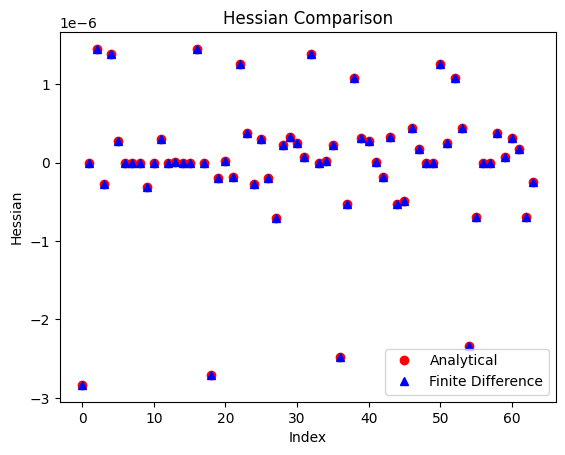

In [ ]:
def FDM_ElasticForce():
  '''
  This function tests the outputs (gradient and hessian) of
  computeGradientHessian() of theElasticForce() against their finite difference
  approximations.
  '''

  # Define a test q vector (4 nodes with 2 DOFs each)
  q = np.array([0.0, 0.0,   # Node 0
    1.0, 0.0,   # Node 1
    2.0, 0.2,   # Node 2
    3.0, 0.5])  # Node 3


  # Create reference lengths: Intentionally perturb it so that axial stretch is not all 0's.
  l_eff_vector = computeReferenceLength(q)
  random_factors = np.random.uniform(0.9, 1.1, size=l_eff_vector.shape)
  l_eff_vector = l_eff_vector * random_factors

  ndof = len(q)

  Y = 5.0
  h = 0.01
  EA = Y * np.pi * h**2.0
  EI = Y * np.pi / 4.0 * h**4.0
  model_choice = 3
  if model_choice == 1: # Linear Elastic
    elForce = ElasticForce(l_eff_vector, EA, EI, h, model_choice, energy_model)
  elif model_choice == 2: # NN-based (simplified, separable)
    elForce = ElasticForce(l_eff_vector, EA, EI, h, model_choice, energy_model)
  else: # Generic NN-based (coupled)
    elForce = ElasticForce(l_eff_vector, EA, EI, h, model_choice, energy_model_generic)

  # Gradient and Hessian and Jacobian
  F_elastic, J_elastic = elForce.computeGradientHessian(q)

  change = 1.0e-5
  J_fdm = np.zeros((ndof,ndof))
  for c in range(ndof):
    q_plus = q.copy()
    q_plus[c] += change
    F_change, _ = elForce.computeGradientHessian(q_plus)
    J_fdm[:,c] = (F_change - F_elastic) / change

  # Plot: Hessians
  plt.figure(1)  # Equivalent to MATLAB's figure(2)
  plt.plot(J_elastic.flatten(), 'ro', label='Analytical')  # Flatten and plot analytical Hessian
  plt.plot(J_fdm.flatten(), 'b^', label='Finite Difference')  # Flatten and plot finite difference Hessian
  plt.legend(loc='best')  # Display the legend
  plt.xlabel('Index')  # X-axis label
  plt.ylabel('Hessian')  # Y-axis label
  plt.title('Hessian Comparison')  # Optional title
  plt.show()  # Show the plot
  return

FDM_ElasticForce()

# Boundary Condition
**This should provide an interface to set and release boundary conditions. This class is passed onto the timeStepper. The class "timeStepper" uses fixedDOFs and fixedIndices during it's linear system solve.**

In [ ]:
class BoundaryConditions:
    def __init__(self, ndof):
        """
        Initialize boundary conditions.

        Parameters:
            ndof (int): Total number of degrees of freedom (DOFs).
        """
        self.ndof = ndof
        self.fixedIndices = []  # List for fixed DOFs
        self.fixedDOFs = []  # List for fixed boundary condition values
        self.freeIndices = list(range(ndof))  # Initialize free DOFs (0 to ndof-1)

    def setBoundaryConditionNode(self, i, x):
        """
        Add or update boundary conditions for a node.

        Parameters:
            i (int): Node index.
            x (numpy.ndarray): Array of size 2 representing boundary condition values.
        """
        if not isinstance(x, np.ndarray) or x.shape != (2,):
            raise ValueError("x must be a numpy array of size 2.")

        # Calculate the DOFs for this node
        dof_1, dof_2 = 2 * i, 2 * i + 1

        # Check if DOFs are already in fixedDOFs
        if dof_1 in self.fixedIndices and dof_2 in self.fixedIndices:
            # Find their indices in fixedDOFs
            index_1 = self.fixedIndices.index(dof_1)
            index_2 = self.fixedIndices.index(dof_2)

            # Update corresponding values in fixedIndices
            self.fixedDOFs[index_1] = x[0]
            self.fixedDOFs[index_2] = x[1]
        else:
            # Add new DOFs and corresponding values
            self.fixedIndices.extend([dof_1, dof_2])
            self.fixedDOFs.extend(x.copy().tolist())  # Convert NumPy array to list for storage

            # Remove the DOFs from freeIndices
            self.freeIndices.remove(dof_1)
            self.freeIndices.remove(dof_2)

    def releaseBoundaryConditionNode(self, i):
        """
        Release the boundary conditions for a node.

        Parameters:
            i (int): Node index to release.
        """
        # Calculate the DOFs for this node
        dof_1, dof_2 = 2 * i, 2 * i + 1

        # Remove DOFs and corresponding indices if they exist
        if dof_1 in self.freeIndices and dof_2 in self.freeIndices:
            # Find their indices in fixedDOFs
            index_1 = self.freeIndices.index(dof_1)
            index_2 = self.freeIndices.index(dof_2)

            # Remove the DOFs from fixedDOFs and corresponding values from fixedIndices
            del self.freeIndices[index_2]  # Remove larger index first
            del self.freeIndices[index_1]
            del self.fixedDOFs[index_2]
            del self.fixedDOFs[index_1]

            # Add the DOFs back to freeIndices
            self.freeIndices.append(dof_1)
            self.freeIndices.append(dof_2)

            # Keep freeIndices sorted
            self.freeIndices.sort()

    def getBoundaryConditions(self):
        """
        Returns the current boundary conditions as a tuple.

        Returns:
            tuple: (fixedDOFs, fixedIndices, freeIndices)
        """
        return self.fixedDOFs, np.array(self.fixedIndices), self.freeIndices

**Test Function**

In [ ]:
# Initialize with 6 DOFs
bc = BoundaryConditions(ndof=6)

# Add boundary conditions for node 0
x0 = np.array([1.0, 2.0])
bc.setBoundaryConditionNode(0, x0)

# Add boundary conditions for node 1
x1 = np.array([3.0, 4.0])
bc.setBoundaryConditionNode(1, x1)

# Check boundary conditions and free DOFs
print("After adding boundary conditions:")
fixedDOFs, fixedIndices, freeIndices = bc.getBoundaryConditions()
print("Fixed DOFs:", fixedDOFs)        # Expected: [0, 1, 2, 3]
print("Fixed Indices:", fixedIndices)  # Expected: [1.0, 2.0, 3.0, 4.0]
print("Free DOFs:", freeIndices)       # Expected: [4, 5]

# Release boundary conditions for node 0
bc.releaseBoundaryConditionNode(0)

# Check boundary conditions and free DOFs after releasing
print("\nAfter releasing boundary conditions for node 0:")
fixedDOFs, fixedIndices, freeIndices = bc.getBoundaryConditions()
print("Fixed DOFs:", fixedDOFs)        # Expected: [2, 3]
print("Fixed Indices:", fixedIndices)  # Expected: [3.0, 4.0]
print("Free DOFs:", freeIndices)       # Expected: [0, 1, 4, 5]

After adding boundary conditions:
Fixed DOFs: [1.0, 2.0, 3.0, 4.0]
Fixed Indices: [0 1 2 3]
Free DOFs: [4, 5]

After releasing boundary conditions for node 0:
Fixed DOFs: [1.0, 2.0, 3.0, 4.0]
Fixed Indices: [0 1 2 3]
Free DOFs: [4, 5]


# Objective Function

In [ ]:
class timeStepper:
  def __init__(self, massVector, dt, qtol, maxIter, g, boundaryCondition, elasticModel):
    self.massVector = massVector
    self.ndof = len(massVector) # Number of degrees of freedom
    if self.ndof % 2 == 1:
      raise ValueError("Constructor of timeStepper: Number of degrees of freedom must be even.")
    self.N = self.ndof // 2 # Number of nodes

    self.dt = dt # Time step size
    self.qtol = qtol # Tolerance on position
    self.maxIter = maxIter # Maximum iterations
    self.g = g # Gravity

    self.Fg = np.zeros(self.ndof)
    self.makeWeight()

    # Make a diagonal mass matrix
    self.massMatrix = np.zeros((self.ndof, self.ndof))
    self.makeMassMatrix()

    # Boundary Condition (BC)
    self.bc = boundaryCondition

    # Model for elastic force
    self.elasticModel = elasticModel

  def makeMassMatrix(self):
    '''
    Compute the mass matrix.
    '''
    for i in range(self.ndof):
      self.massMatrix[i,i] = self.massVector[i]

  def makeWeight(self):
    '''
      Compute the weight vector.
    '''
    if len(g) != 2:
      raise ValueError("makeWeight of timeStepper: Gravity vector must be of length 2.")
    for i in range(self.N):
      self.Fg[2*i:2*i+2] = self.massVector[2*i:2*i+2] * self.g

  def beforeTimeStep(self) -> None:
    '''
    Take care of any business that should be done BEFORE a time step.
    '''
    pass


  def afterTimeStep(self) -> None:
    '''
    Take care of any business that should be done AFTER a time step.
      '''
    return

  def simulate(self, q_guess, q_old, u_old, a_old):
    '''
    The main simulation loop that takes in the OLD state (DOFs, their first
    and second derivatives, i.e., velocities and accelerations) and outputs
    the NEW state.
    '''

    q_new = q_guess.copy()

    # Impose boundary conditions
    for k in range(len(bc.fixedIndices)):
      q_new[bc.fixedIndices[k]] = bc.fixedDOFs[k]

    error = 10 * self.qtol # Initialize error to a value larger than tolerance
    iter = 0 # Iteration number

    while error > self.qtol and iter < self.maxIter:
      #
      # Personal notes: I want it to quit without linear solve when steady
      # state is achieved. Perhaps, set a utol or ftol for that.
      # Right now, it executes linear solve no matter what.
      #

      gradE, hessE = self.elasticModel.computeGradientHessian(q_new)
      inertiaF = (massVector / dt) * (((q_new - q_old) / dt) - u_old)

      # Compute the force and Jacobian
      force = inertiaF + gradE - self.Fg
      J = (self.massMatrix / dt**2) + hessE

      # Extract the free components
      freeIndex = self.bc.freeIndices
      f_free = force[freeIndex]
      J_free = J[np.ix_(freeIndex, freeIndex)]
      dq_free = np.linalg.solve(J_free, f_free)

      # Update error and iteration number
      error = np.linalg.norm(dq_free)
      iter += 1

      print(f'iter={iter} error={error}')

      # Update the DOFs
      q_new[freeIndex] = q_new[freeIndex] - dq_free


    u_new = (q_new - q_old) / dt
    a_new = force / self.massVector

    if error < self.qtol:
      flag = True # Simulation converged successfully
    else:
      flag = False # Simulation did not converge

    return q_new, u_new, a_new, flag

# Main Function

In [ ]:
# Geometry
N = 10 # Number of nodes
ndof = N * 2 # Number of DOFs
RodLength = 0.1 # Length of rod in meter
q = np.zeros(ndof)
for k in range(N):
  q[2*k] = k * RodLength / (N-1.0)
  q[2*k+1] = 0

# Compute l_eff
# TODO: Should be delegated to elastic energy model
l_eff_vector = computeReferenceLength(q)

# Set up boundary condition
bc = BoundaryConditions(ndof)

# Set up elastic energy model
Y = 10.0e8
h = 0.001
EA = Y * np.pi * h**2.0
EI = Y * np.pi / 4.0 * h**4.0
model_choice = 1 # 1 is analytical, 2 is separable (simplified) NN, and 3 is generic
if model_choice == 1 or model_choice == 2:
  elForce = ElasticForce(l_eff_vector, EA, EI, h, model_choice, energy_model)
else:
  elForce = ElasticForce(l_eff_vector, EA, EI, h, model_choice, energy_model_generic)

# Mass Vector
totalMass = 0.2
massVector = np.zeros(ndof)
massVector[:] = totalMass / N

# Define timeStepper
dt = 0.01 # Time step size in second
qtol = 0.001 # Tolerance on position change
maxIter = 10 # Maximum number of iterations
g = np.array([0.0, -9.81])
stepper = timeStepper(massVector, dt, qtol, maxIter, g, bc, elForce)

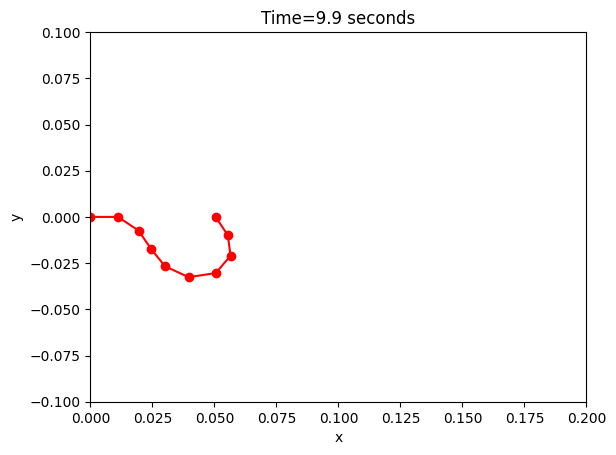

iter=1 error=4.479409856542352e-05
iter=1 error=4.478968452707367e-05
iter=1 error=4.4785506847293084e-05
iter=1 error=4.4781567110968866e-05
iter=1 error=4.477786691346357e-05
iter=1 error=4.4774407860675946e-05
iter=1 error=4.4771191569021885e-05
iter=1 error=4.476821966553883e-05
iter=1 error=4.4765493787821994e-05


In [ ]:
from IPython.display import clear_output

# Boundary conditions
bc.setBoundaryConditionNode(0, q[0:2])
bc.setBoundaryConditionNode(1, q[2:4])

# Main simulation loop
totalTime = 10.0 # Total Simulation Time
q_old = q.copy()
u_old = np.zeros(ndof)
a_old = np.zeros(ndof)

time_iter = 0
for t in np.arange(0, totalTime, dt):

  # Slowly move the last node
  targetNodeLocation = np.array([RodLength - 0.05 * t * RodLength, 0.0])
  bc.setBoundaryConditionNode(N-1, targetNodeLocation)

  q_new, u_new, a_new, flag = stepper.simulate(q_old, q_old, u_old, a_old)

  if flag == False:
    print(f"Simulation did not converge at time {t} seconds.")
    break

  q_old = q_new.copy()
  u_old = u_new.copy()
  a_old = a_new.copy()

  # Plot
  if time_iter % 10 == 0 or time_iter == 0:
    clear_output()
    x = q_old[0:ndof:2]
    y = q_old[1:ndof:2]
    plt.figure(1)
    plt.plot(x, y, 'ro-')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Time={t} seconds')
    plt.xlim([0, 2.0*RodLength])
    plt.ylim([-RodLength, RodLength])
    plt.show()

  time_iter += 1

In [ ]:
a_old

array([ 3.14896387e+01, -2.68603920e+02,  8.93450267e+01,  3.86575185e+02,
        2.24654401e-02,  2.73982052e-02,  6.03625260e-02,  4.04365123e-02,
        7.33223483e-02,  5.63655053e-02,  3.83034800e-02,  2.56588411e-02,
        7.38767666e-02, -1.03907661e-01,  7.34132918e+00, -8.06902415e+01,
        6.87496537e+01, -6.19443977e+01, -1.96345222e+02,  1.22675085e+02])